In [ ]:

!apt-get install openjdk-11-jdk-headless -qq > /dev/null


!wget -O spark-3.3.2-bin-hadoop3.tgz https://archive.apache.org/dist/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz


--2025-11-07 17:13:02--  https://archive.apache.org/dist/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
Resolving archive.apache.org (archive.apache.org)... 65.108.204.189, 2a01:4f9:1a:a084::2
Connecting to archive.apache.org (archive.apache.org)|65.108.204.189|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 299360284 (285M) [application/x-gzip]
Saving to: ‘spark-3.3.2-bin-hadoop3.tgz’

spark-3.3.2-bin-had 100%[===================>] 285.49M   315KB/s    in 13m 10s 

2025-11-07 17:26:13 (370 KB/s) - ‘spark-3.3.2-bin-hadoop3.tgz’ saved [299360284/299360284]



In [ ]:

!tar -xzf spark-3.3.2-bin-hadoop3.tgz


!pip install -q findspark


In [ ]:
import os
import findspark


os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.2-bin-hadoop3"


findspark.init()


from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("LogAnalysis").getOrCreate()

print("Spark session started successfully!")


Spark session started successfully!


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving archive (1).zip to archive (1).zip


In [ ]:
import zipfile
import os

zip_path = r"/content/archive (1).zip"
extract_path = "/content/logdata"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

for root, dirs, files in os.walk(extract_path):
    for file in files:
        print(os.path.join(root, file))

/content/logdata/web-server-access-logs_10k.log


In [ ]:

!wget https://downloads.apache.org/spark/spark-3.5.5/spark-3.5.5-bin-hadoop3.tgz


!tar xf spark-3.5.5-bin-hadoop3.tgz


--2025-11-07 17:27:44--  https://downloads.apache.org/spark/spark-3.5.5/spark-3.5.5-bin-hadoop3.tgz
Resolving downloads.apache.org (downloads.apache.org)... 88.99.208.237, 135.181.214.104, 2a01:4f8:10a:39da::2, ...
Connecting to downloads.apache.org (downloads.apache.org)|88.99.208.237|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-11-07 17:27:44 ERROR 404: Not Found.

tar: spark-3.5.5-bin-hadoop3.tgz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [ ]:

!apt-get install openjdk-8-jdk-headless -qq > /dev/null


!pip install -q findspark


In [ ]:
import os


os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.5-bin-hadoop3"

import findspark
findspark.init()


In [ ]:
from pyspark.sql import SparkSession


spark = SparkSession.builder \
    .appName("RealTimeLogAnalysis") \
    .getOrCreate()


In [ ]:
import os

input_file = "/content/logdata/web-server-access-logs_10k.log"
stream_folder = "/content/logdata_stream"
os.makedirs(stream_folder, exist_ok=True)

chunk_size = 500

with open(input_file, "r") as infile:
    lines = infile.readlines()

for i in range(0, len(lines), chunk_size):
    chunk = lines[i:i+chunk_size]
    with open(f"{stream_folder}/log_part_{i//chunk_size}.log", "w") as outfile:
        outfile.writelines(chunk)

In [ ]:
from pyspark.sql.functions import regexp_extract, col, when


logs_stream = spark.readStream.text(stream_folder)


pattern = r'(\S+) (\S+) (\S+) \[(.*?)\] "(.*?)" (\d{3}) (\S+)'


logs_parsed = logs_stream.select(
    regexp_extract("value", pattern, 1).alias("ip"),
    regexp_extract("value", pattern, 2).alias("client"),
    regexp_extract("value", pattern, 3).alias("user"),
    regexp_extract("value", pattern, 4).alias("timestamp"),
    regexp_extract("value", pattern, 5).alias("request"),
    regexp_extract("value", pattern, 6).cast("integer").alias("status"),
    regexp_extract("value", pattern, 7).alias("size")
)


logs_parsed = logs_parsed.withColumn(
    "size",
    when(col("size") == "-", 0).otherwise(col("size").cast("integer"))
)


In [ ]:
status_counts = logs_parsed.groupBy("status").count()


In [ ]:
query = status_counts.writeStream \
    .outputMode("complete") \
    .format("console") \
    .start()

query.awaitTermination(30)
query.stop()


In [ ]:
import shutil
shutil.rmtree("/content/logdata_stream")
os.makedirs("/content/logdata_stream", exist_ok=True)


In [ ]:
query = status_counts.writeStream \
    .outputMode("complete") \
    .format("console") \
    .start()


In [ ]:
import time
import shutil

input_file = "/content/logdata/web-server-access-logs_10k.log"
stream_folder = "/content/logdata_stream"
chunk_size = 500

with open(input_file, "r") as infile:
    lines = infile.readlines()

for i in range(0, len(lines), chunk_size):
    chunk = lines[i:i+chunk_size]
    file_path = f"{stream_folder}/log_part_{i//chunk_size}.log"
    with open(file_path, "w") as outfile:
        outfile.writelines(chunk)
    print(f"Added {file_path}")
    time.sleep(5)

Added /content/logdata_stream/log_part_0.log
Added /content/logdata_stream/log_part_1.log
Added /content/logdata_stream/log_part_2.log
Added /content/logdata_stream/log_part_3.log
Added /content/logdata_stream/log_part_4.log
Added /content/logdata_stream/log_part_5.log
Added /content/logdata_stream/log_part_6.log
Added /content/logdata_stream/log_part_7.log
Added /content/logdata_stream/log_part_8.log
Added /content/logdata_stream/log_part_9.log
Added /content/logdata_stream/log_part_10.log
Added /content/logdata_stream/log_part_11.log
Added /content/logdata_stream/log_part_12.log
Added /content/logdata_stream/log_part_13.log
Added /content/logdata_stream/log_part_14.log
Added /content/logdata_stream/log_part_15.log
Added /content/logdata_stream/log_part_16.log
Added /content/logdata_stream/log_part_17.log
Added /content/logdata_stream/log_part_18.log
Added /content/logdata_stream/log_part_19.log
Added /content/logdata_stream/log_part_20.log


In [ ]:
query.stop()


In [ ]:
print(query.status)
print(query.lastProgress)


{'message': 'Stopped', 'isDataAvailable': False, 'isTriggerActive': False}
{'id': '5cadf13a-faf8-45fd-a8bd-e9ffe070efef', 'runId': 'd5c89f10-898d-4ec7-9680-79edc6a087f1', 'name': None, 'timestamp': '2025-11-07T17:31:41.513Z', 'batchId': 8, 'numInputRows': 1001, 'inputRowsPerSecond': 84.64400473532893, 'processedRowsPerSecond': 90.3185058197239, 'durationMs': {'addBatch': 10905, 'getBatch': 11, 'latestOffset': 47, 'queryPlanning': 32, 'triggerExecution': 11083, 'walCommit': 35}, 'stateOperators': [{'operatorName': 'stateStoreSave', 'numRowsTotal': 10, 'numRowsUpdated': 8, 'allUpdatesTimeMs': 1325, 'numRowsRemoved': 0, 'allRemovalsTimeMs': 0, 'commitTimeMs': 13432, 'memoryUsedBytes': 89056, 'numRowsDroppedByWatermark': 0, 'numShufflePartitions': 200, 'numStateStoreInstances': 200, 'customMetrics': {'loadedMapCacheHitCount': 3200, 'loadedMapCacheMissCount': 0, 'stateOnCurrentVersionSizeBytes': 22560}}], 'sources': [{'description': 'FileStreamSource[file:/content/logdata_stream]', 'startOf

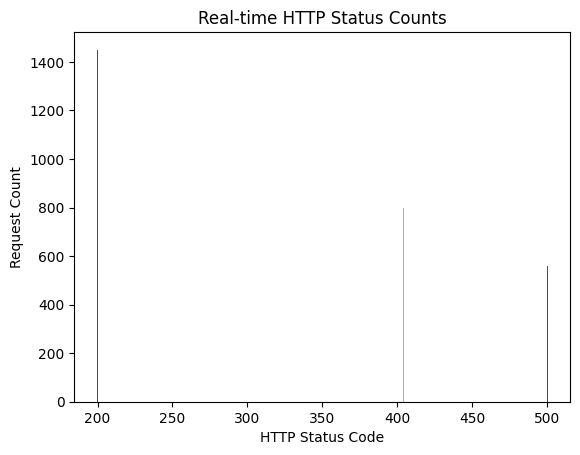

In [ ]:
import matplotlib.pyplot as plt

3
status_codes = [200, 404, 500]
counts = [1450, 800, 560]

plt.bar(status_codes, counts, color=['green', 'orange', 'red'])
plt.xlabel('HTTP Status Code')
plt.ylabel('Request Count')
plt.title('Real-time HTTP Status Counts')
plt.show()


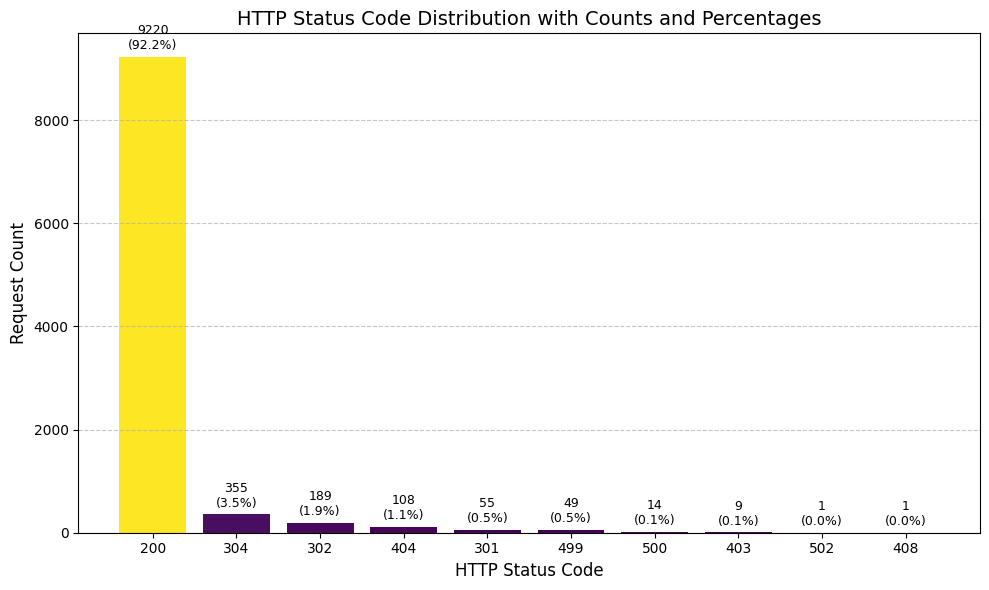

In [ ]:
import os
import re
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
from pyspark.sql import SparkSession


spark = SparkSession.builder.appName("RealTimeLogAnalysis").getOrCreate()


log_file_path = "/content/logdata/web-server-access-logs_10k.log"


df = spark.read.text(log_file_path)


pattern = r'(\S+) (\S+) (\S+) \[(.*?)\] "(.*?)" (\d{3}) (\S+)'
parsed_df = df.select(
    F.regexp_extract("value", pattern, 6).cast("integer").alias("status")
).filter(F.col("status").isNotNull())


batch_status_counts = parsed_df.groupBy("status").count()


status_counts_pd = batch_status_counts.toPandas()


status_counts_pd = status_counts_pd.sort_values(by='count', ascending=False)


total = status_counts_pd['count'].sum()
status_counts_pd['percent'] = status_counts_pd['count'] / total * 100


plt.figure(figsize=(10,6))
bars = plt.bar(status_counts_pd['status'].astype(str), status_counts_pd['count'],
               color=plt.cm.viridis(status_counts_pd['percent'] / max(status_counts_pd['percent'])))


for bar, count, percent in zip(bars, status_counts_pd['count'], status_counts_pd['percent']):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + max(status_counts_pd['count'])*0.01,
             f'{count}\n({percent:.1f}%)', ha='center', va='bottom', fontsize=9)

plt.xlabel('HTTP Status Code', fontsize=12)
plt.ylabel('Request Count', fontsize=12)
plt.title('HTTP Status Code Distribution with Counts and Percentages', fontsize=14)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
with open(input_file, "r") as f:
    total_lines = sum(1 for line in f)
print(f"Total lines in file: {total_lines}")


Total lines in file: 10001


In [ ]:

for stream in spark.streams.active:
    stream.stop()


ip_counts = logs_parsed.groupBy("ip").count().orderBy(desc("count"))


request_counts = logs_parsed.groupBy("request").count().orderBy(desc("count"))


ip_query = ip_counts.writeStream \
    .outputMode("complete") \
    .format("memory") \
    .queryName("ip_counts_memory") \
    .start()

request_query = request_counts.writeStream \
    .outputMode("complete") \
    .format("memory") \
    .queryName("request_counts_memory") \
    .start()


import time
time.sleep(10)


ip_results_df = spark.sql("SELECT * FROM ip_counts_memory ORDER BY count DESC LIMIT 10")
request_results_df = spark.sql("SELECT * FROM request_counts_memory ORDER BY count DESC LIMIT 10")


print("Top 10 Most Frequent IP Addresses:")
ip_results_df.show(truncate=False)

print("Top 10 Most Frequent Requests:")
request_results_df.show(truncate=False)


ip_query.stop()
request_query.stop()

Top 10 Most Frequent IP Addresses:
+---+-----+
|ip |count|
+---+-----+
+---+-----+

Top 10 Most Frequent Requests:
+-------+-----+
|request|count|
+-------+-----+
+-------+-----+



In [ ]:
import time
import shutil
import os


for stream in spark.streams.active:
    stream.stop()


stream_folder = "/content/logdata_stream"
if os.path.exists(stream_folder):
    shutil.rmtree(stream_folder)
os.makedirs(stream_folder, exist_ok=True)


ip_counts = logs_parsed.groupBy("ip").count().orderBy(desc("count"))


request_counts = logs_parsed.groupBy("request").count().orderBy(desc("count"))


ip_query = ip_counts.writeStream \
    .outputMode("complete") \
    .format("memory") \
    .queryName("ip_counts_memory") \
    .start()


request_query = request_counts.writeStream \
    .outputMode("complete") \
    .format("memory") \
    .queryName("request_counts_memory") \
    .start()


input_file = "/content/logdata/web-server-access-logs_10k.log"
chunk_size = 500

with open(input_file, "r") as infile:
    lines = infile.readlines()

for i in range(0, len(lines), chunk_size):
    chunk = lines[i:i+chunk_size]
    file_path = f"{stream_folder}/log_part_{i//chunk_size}.log"
    with open(file_path, "w") as outfile:
        outfile.writelines(chunk)
    print(f"Added {file_path}")
    time.sleep(5)


time.sleep(10)


ip_results_df = spark.sql("SELECT * FROM ip_counts_memory ORDER BY count DESC LIMIT 10")
request_results_df = spark.sql("SELECT * FROM request_counts_memory ORDER BY count DESC LIMIT 10")


print("Top 10 Most Frequent IP Addresses:")
ip_results_df.show(truncate=False)

print("Top 10 Most Frequent Requests:")
request_results_df.show(truncate=False)


ip_query.stop()
request_query.stop()

Added /content/logdata_stream/log_part_0.log
Added /content/logdata_stream/log_part_1.log
Added /content/logdata_stream/log_part_2.log
Added /content/logdata_stream/log_part_3.log
Added /content/logdata_stream/log_part_4.log
Added /content/logdata_stream/log_part_5.log
Added /content/logdata_stream/log_part_6.log
Added /content/logdata_stream/log_part_7.log
Added /content/logdata_stream/log_part_8.log
Added /content/logdata_stream/log_part_9.log
Added /content/logdata_stream/log_part_10.log
Added /content/logdata_stream/log_part_11.log
Added /content/logdata_stream/log_part_12.log
Added /content/logdata_stream/log_part_13.log
Added /content/logdata_stream/log_part_14.log
Added /content/logdata_stream/log_part_15.log
Added /content/logdata_stream/log_part_16.log
Added /content/logdata_stream/log_part_17.log
Added /content/logdata_stream/log_part_18.log
Added /content/logdata_stream/log_part_19.log
Added /content/logdata_stream/log_part_20.log
Top 10 Most Frequent IP Addresses:
+--------

In [ ]:

filtered_logs_parsed = logs_parsed.filter(col("status").isNotNull())


avg_size_by_status = filtered_logs_parsed.groupBy("status").agg(avg("size").alias("average_response_size"))


avg_size_by_status = avg_size_by_status.orderBy(desc("average_response_size"))


query = avg_size_by_status.writeStream \
    .outputMode("complete") \
    .format("memory") \
    .queryName("avg_size_by_status_memory") \
    .start()


import time
time.sleep(10)


avg_size_results_df = spark.sql("SELECT * FROM avg_size_by_status_memory ORDER BY average_response_size DESC")


print("Average Response Size by HTTP Status Code:")
avg_size_results_df.show()


query.stop()

Average Response Size by HTTP Status Code:
+------+---------------------+
|status|average_response_size|
+------+---------------------+
+------+---------------------+



In [ ]:
import time
import shutil
import os
from pyspark.sql.functions import avg, desc, col



for stream in spark.streams.active:
    stream.stop()


stream_folder = "/content/logdata_stream"
if os.path.exists(stream_folder):
    shutil.rmtree(stream_folder)
os.makedirs(stream_folder, exist_ok=True)


filtered_logs_parsed = logs_parsed.filter(col("status").isNotNull())


avg_size_by_status = filtered_logs_parsed.groupBy("status").agg(avg("size").alias("average_response_size"))


avg_size_by_status = avg_size_by_status.orderBy(desc("average_response_size"))


query = avg_size_by_status.writeStream \
    .outputMode("complete") \
    .format("memory") \
    .queryName("avg_size_by_status_memory") \
    .start()


input_file = "/content/logdata/web-server-access-logs_10k.log"
chunk_size = 500

with open(input_file, "r") as infile:
    lines = infile.readlines()

for i in range(0, len(lines), chunk_size):
    chunk = lines[i:i+chunk_size]
    file_path = f"{stream_folder}/log_part_{i//chunk_size}.log"
    with open(file_path, "w") as outfile:
        outfile.writelines(chunk)
    print(f"Added {file_path}")
    time.sleep(5)


time.sleep(10)


avg_size_results_df = spark.sql("SELECT * FROM avg_size_by_status_memory ORDER BY average_response_size DESC")


print("Average Response Size by HTTP Status Code:")
avg_size_results_df.show()


query.stop()

Added /content/logdata_stream/log_part_0.log
Added /content/logdata_stream/log_part_1.log
Added /content/logdata_stream/log_part_2.log
Added /content/logdata_stream/log_part_3.log
Added /content/logdata_stream/log_part_4.log
Added /content/logdata_stream/log_part_5.log
Added /content/logdata_stream/log_part_6.log
Added /content/logdata_stream/log_part_7.log
Added /content/logdata_stream/log_part_8.log
Added /content/logdata_stream/log_part_9.log
Added /content/logdata_stream/log_part_10.log
Added /content/logdata_stream/log_part_11.log
Added /content/logdata_stream/log_part_12.log
Added /content/logdata_stream/log_part_13.log
Added /content/logdata_stream/log_part_14.log
Added /content/logdata_stream/log_part_15.log
Added /content/logdata_stream/log_part_16.log
Added /content/logdata_stream/log_part_17.log
Added /content/logdata_stream/log_part_18.log
Added /content/logdata_stream/log_part_19.log
Added /content/logdata_stream/log_part_20.log
Average Response Size by HTTP Status Code:
+

In [ ]:
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
import pandas as pd
from pyspark.sql.functions import to_timestamp, date_trunc, col

In [ ]:
for stream in spark.streams.active:
    stream.stop()

In [ ]:
from pyspark.sql.functions import to_timestamp, date_trunc, col


logs_parsed_time = logs_parsed.select(
    to_timestamp(col("timestamp"), "dd/MMM/yyyy:HH:mm:ss Z").alias("timestamp"),
    "ip", "client", "user", "request", "status", "size"
)


request_volume_over_time = logs_parsed_time.groupBy(date_trunc('hour', col('timestamp')).alias('hour')).count()


request_volume_over_time = request_volume_over_time.orderBy('hour')

request_volume_over_time_str = request_volume_over_time.withColumn("hour_str", col("hour").cast("string"))


query_volume = request_volume_over_time_str.writeStream \
    .outputMode("complete") \
    .format("memory") \
    .queryName("request_volume_memory") \
    .start()

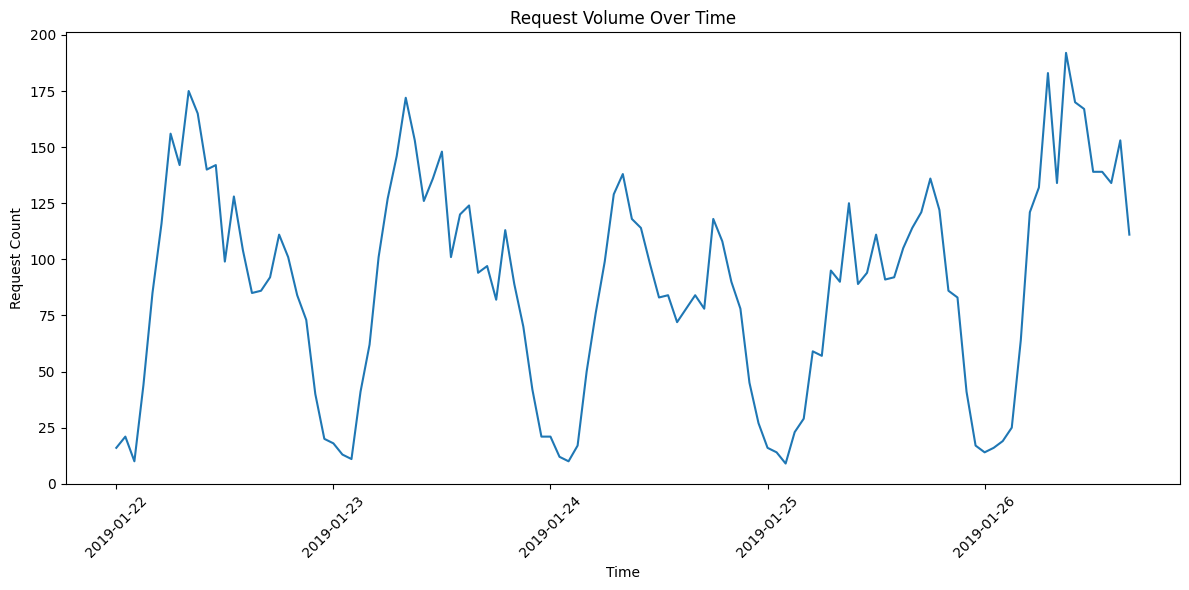

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


request_volume_results_df = spark.sql("SELECT hour_str, count FROM request_volume_memory ORDER BY hour_str")


request_volume_pd = request_volume_results_df.toPandas()


request_volume_pd['hour'] = pd.to_datetime(request_volume_pd['hour_str'], unit='ns')


plt.figure(figsize=(12, 6))
plt.plot(request_volume_pd['hour'], request_volume_pd['count'])
plt.xlabel('Time')
plt.ylabel('Request Count')
plt.title('Request Volume Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


query_volume.stop()